In [1]:
!pip install yellowbrick

## Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

In [3]:
# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


pd.options.display.width = None

## Reading the CSVs

In [4]:
## Reading the 4 csvs 
historical_transactions = pd.read_csv('data/historical_transactions.csv')
merchants = pd.read_csv('data/merchants.csv')
new_merchant_transactions = pd.read_csv('data/new_merchant_transactions.csv')
userscore = pd.read_csv('data/userscore.csv')

In [5]:
merchants.head()
historical_transactions.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [6]:
userscore.head()

,card_id,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_92a2005557,Jun-17,5,2,1,-0.820283
1,C_ID_3d0044924f,Jan-17,4,1,0,0.392913
2,C_ID_d639edf6cd,Aug-16,2,2,0,0.688056
3,C_ID_186d6a6901,Sep-17,4,3,0,0.142495
4,C_ID_cdbd2c0db2,Nov-17,1,3,0,-0.159749


## Data Preprocessing

### 1. Merging the Dataframes

In [7]:
## Merging the new_merchant_transactions and historical_transactions In one dataframe since
## they have the exact same columns
transactions = pd.concat([historical_transactions, new_merchant_transactions])

In [8]:
# Merge the userscore and tranactions based on the card_id column [left merge to get all the rows from both of the dataframes] 
# we made the merge left on usersocre as it's the dataset that containts the target label
score_and_transactions = pd.merge(userscore,transactions, on='card_id', how='left')

In [9]:
## Last Megere with merchants.csv on Merchant ID 
data = pd.merge(score_and_transactions,merchants, on='merchant_id', how='left')
data.columns

Index(['card_id', 'first_active_month', 'feature_1', 'feature_2', 'feature_3',
       'score', 'authorized_flag', 'city_id_x', 'category_1_x', 'installments',
       'category_3', 'merchant_category_id_x', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2_x', 'state_id_x',
       'subsector_id_x', 'merchant_group_id', 'merchant_category_id_y',
       'subsector_id_y', 'numerical_1', 'numerical_2', 'category_1_y',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id_y', 'state_id_y', 'category_2_y'],
      dtype='object')

In [10]:
## shape cheking
transactions.shape
score_and_transactions.shape
data.shape

(31075392, 14)

(19249694, 19)

(20025733, 40)

In [11]:
## checking for duplicates 
data.duplicated().sum()

0

### 2. Feature selection & Null analysis

In [12]:
# Dropping any irrelevant columns from the dataframe
data.drop(['subsector_id_x', 'subsector_id_y', 'city_id_x', 'city_id_y', 'state_id_x', 'state_id_y',
           'category_1_x', 'category_1_y', 'category_2_x', 'category_2_y', 'category_3', 'category_4', 
           'merchant_group_id', 'merchant_category_id_x', 'merchant_category_id_y'], axis=1, inplace=True)

In [13]:
data.shape
data.head()

(20025733, 25)

,card_id,first_active_month,feature_1,feature_2,feature_3,score,authorized_flag,installments,merchant_id,month_lag,...,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
0,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_cc72dac895,-3,...,A,1.07,1.085076,3.0,1.13,1.091386,6.0,1.16,1.126131,12.0
1,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_c9c0f1cb3f,-7,...,D,1.20,1.197449,3.0,1.13,1.159456,6.0,1.12,1.213672,12.0
2,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_36f9e41993,-6,...,B,1.02,1.006072,3.0,1.08,1.010842,6.0,1.26,1.061942,12.0
3,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_b790230ee9,-2,...,D,1.09,0.998382,3.0,0.90,0.874595,6.0,0.87,0.834836,12.0
4,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_ab67f6c982,-7,...,C,0.92,0.927273,3.0,0.93,0.937879,6.0,0.88,0.880952,12.0


In [14]:
## checking for NUll values 
missing_percent = round(data.isnull().sum() / len(data) * 100, 2).sort_values(ascending=False)
missing_percent

avg_sales_lag12                0.54
avg_sales_lag6                 0.54
avg_sales_lag3                 0.54
numerical_1                    0.51
numerical_2                    0.51
avg_purchases_lag12            0.51
active_months_lag6             0.51
avg_purchases_lag6             0.51
active_months_lag3             0.51
avg_purchases_lag3             0.51
most_recent_purchases_range    0.51
most_recent_sales_range        0.51
active_months_lag12            0.51
merchant_id                    0.51
first_active_month             0.00
purchase_date                  0.00
purchase_amount                0.00
month_lag                      0.00
installments                   0.00
authorized_flag                0.00
score                          0.00
feature_3                      0.00
feature_2                      0.00
feature_1                      0.00
card_id                        0.00
dtype: float64

In [15]:
## Since the NUll percentages is considred to be very small i choose to drop NULLs
data.dropna(inplace=True)

In [16]:
missing_percent = round(data.isnull().sum() / len(data) * 100, 2).sort_values(ascending=False)
missing_percent

data.shape

card_id                        0.0
numerical_2                    0.0
avg_purchases_lag12            0.0
avg_sales_lag12                0.0
active_months_lag6             0.0
avg_purchases_lag6             0.0
avg_sales_lag6                 0.0
active_months_lag3             0.0
avg_purchases_lag3             0.0
avg_sales_lag3                 0.0
most_recent_purchases_range    0.0
most_recent_sales_range        0.0
numerical_1                    0.0
first_active_month             0.0
purchase_date                  0.0
purchase_amount                0.0
month_lag                      0.0
merchant_id                    0.0
installments                   0.0
authorized_flag                0.0
score                          0.0
feature_3                      0.0
feature_2                      0.0
feature_1                      0.0
active_months_lag12            0.0
dtype: float64

(19917593, 25)

In [17]:
## since the scope of our problem is clustering based on the  users purchase behaviour  and i will focus on the yearly activity so
## i will drop the following columns
data.drop(['avg_sales_lag12', 'avg_sales_lag3', 'avg_sales_lag6', 'active_months_lag6', 'active_months_lag3','most_recent_sales_range'], axis=1, inplace=True)

In [18]:
data.drop(['avg_purchases_lag3', 'avg_purchases_lag6'], axis=1, inplace=True)

In [19]:
data.head()
data.shape

,card_id,first_active_month,feature_1,feature_2,feature_3,score,authorized_flag,installments,merchant_id,month_lag,purchase_amount,purchase_date,numerical_1,numerical_2,most_recent_purchases_range,avg_purchases_lag12,active_months_lag12
0,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,17.154803,16.797867,A,1.126131,12.0
1,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00,-0.007896,-0.057471,D,1.213672,12.0
2,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16,0.150742,-0.057471,B,1.061942,12.0
3,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_b790230ee9,-2,-0.610167,2017-12-15 12:06:58,-0.047556,-0.047556,D,0.834836,12.0
4,C_ID_92a2005557,Jun-17,5,2,1,-0.820283,Y,0,M_ID_ab67f6c982,-7,-0.307232,2017-07-08 15:13:18,-0.027726,-0.047556,C,0.880952,12.0


(19917593, 17)

In [20]:
data.columns

Index(['card_id', 'first_active_month', 'feature_1', 'feature_2', 'feature_3',
       'score', 'authorized_flag', 'installments', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'numerical_1', 'numerical_2',
       'most_recent_purchases_range', 'avg_purchases_lag12',
       'active_months_lag12'],
      dtype='object')

### 3. some feature engineering

In [21]:
## The total purchases for each user 
data['total_spending'] = data['purchase_amount'].groupby(data['card_id']).transform('sum')

In [22]:
## The average spennding for each user
data['avg_spending'] = data['purchase_amount'].groupby(data['card_id']).transform('mean')

In [23]:
# The no. of transactions / purchase made by each user
##data['purchase_frequency'] = data['card_id'].value_counts()

In [24]:
## Getting the recency of each transaction 
data['purchase_recency'] = pd.to_datetime(data['purchase_date']).max() - pd.to_datetime(data['purchase_date'])

In [25]:
## The number of merchants that each user deals with 
##data['merchant_diversity'] = data.groupby('card_id')['merchant_id'].nunique()

In [26]:
## The variance in purchase amount
data['purchase_amount_variance'] = data['purchase_amount'].groupby(data['card_id']).transform('var')

In [27]:
data.tail(20)

,card_id,first_active_month,feature_1,feature_2,feature_3,score,authorized_flag,installments,merchant_id,month_lag,...,purchase_date,numerical_1,numerical_2,most_recent_purchases_range,avg_purchases_lag12,active_months_lag12,total_spending,avg_spending,purchase_recency,purchase_amount_variance
20025713,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,1,M_ID_e5374dabc0,-6,...,2017-08-24 18:01:24,-0.057471,-0.057471,A,0.583477,12.0,-88.981263,-0.601225,249 days 05:58:35,0.067181
20025714,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,1,M_ID_e5374dabc0,-7,...,2017-07-30 21:24:06,-0.057471,-0.057471,A,0.583477,12.0,-88.981263,-0.601225,274 days 02:35:53,0.067181
20025715,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,1,M_ID_e5374dabc0,-7,...,2017-07-16 17:48:36,-0.057471,-0.057471,A,0.583477,12.0,-88.981263,-0.601225,288 days 06:11:23,0.067181
20025716,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,1,M_ID_e5374dabc0,-6,...,2017-08-16 12:10:23,-0.057471,-0.057471,A,0.583477,12.0,-88.981263,-0.601225,257 days 11:49:36,0.067181
20025717,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,1,M_ID_ec24d672a3,-3,...,2017-11-24 21:04:49,-0.057471,-0.057471,A,0.568016,12.0,-88.981263,-0.601225,157 days 02:55:10,0.067181
20025718,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,2,M_ID_00a6ca8a8a,-1,...,2018-01-24 09:14:28,-0.047556,-0.057471,E,16.219780,7.0,-88.981263,-0.601225,96 days 14:45:31,0.067181
20025719,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,2,M_ID_00a6ca8a8a,-1,...,2018-01-24 09:14:28,-0.057471,-0.057471,A,0.752641,12.0,-88.981263,-0.601225,96 days 14:45:31,0.067181
20025720,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,N,1,M_ID_49d4a8510e,-3,...,2017-11-13 14:24:07,-0.057471,-0.057471,B,0.688112,12.0,-88.981263,-0.601225,168 days 09:35:52,0.067181
20025721,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,1,M_ID_e5374dabc0,-3,...,2017-11-23 14:57:11,-0.057471,-0.057471,A,0.583477,12.0,-88.981263,-0.601225,158 days 09:02:48,0.067181
20025722,C_ID_92c9984c58,Jul-17,3,1,1,-1.859413,Y,1,M_ID_e5374dabc0,-6,...,2017-08-24 17:47:51,-0.057471,-0.057471,A,0.583477,12.0,-88.981263,-0.601225,249 days 06:12:08,0.067181


In [28]:
## Doing some aggreations on CardID
card_data_1 = data.groupby('card_id')['purchase_amount'].agg(['min', 'max', 'mean']).reset_index()
card_data_1.columns = ['card_id','min_purchase_amount', 'max_purchase_amount', 'mean_purchase_amount']

In [29]:
## total spending
card_data_2 = data.groupby('card_id')['total_spending'].max().reset_index()
card_data_2.columns = ['card_id','total_spending']
card_data_2

,card_id,total_spending
0,C_ID_00007093c1,-78.830313
1,C_ID_0001506ef0,-36.769844
2,C_ID_000183fdda,-78.623804
3,C_ID_00027503e2,-33.329209
4,C_ID_0002c7c2c1,-50.970769
...,...,...
201912,C_ID_fffeced303,-134.396385
201913,C_ID_fffeed3a89,-114.249049
201914,C_ID_ffff579d3a,-80.957030
201915,C_ID_ffff828181,-125.774248


In [30]:
## recency
card_data_3 = data.groupby('card_id')['purchase_recency'].agg(['min', 'max', 'median']).reset_index()
card_data_3.columns = ['card_id','min_purchase_recency', 'max_purchase_recency', 'mean_purchase_recency']
card_data_3

,card_id,min_purchase_recency,max_purchase_recency,mean_purchase_recency
0,C_ID_00007093c1,21 days 07:36:00,440 days 09:59:16,266 days 23:12:11
1,C_ID_0001506ef0,39 days 14:45:29,471 days 07:43:58,154 days 10:32:33
2,C_ID_000183fdda,0 days 09:00:06,266 days 14:10:45,135 days 04:17:38
3,C_ID_00027503e2,101 days 11:52:32,338 days 13:38:43,250 days 11:54:06
4,C_ID_0002c7c2c1,37 days 15:16:22,380 days 08:41:10,206 days 02:15:57
...,...,...,...,...
201912,C_ID_fffeced303,3 days 09:05:51,384 days 05:23:59,202 days 20:40:15
201913,C_ID_fffeed3a89,0 days 03:33:19,177 days 23:44:46,93 days 09:42:09
201914,C_ID_ffff579d3a,40 days 15:04:25,265 days 11:26:16,217 days 06:46:57
201915,C_ID_ffff828181,1 days 05:00:30,480 days 08:32:26,220 days 08:46:12


In [31]:
## average spending
card_data_4 = data.groupby('card_id')['avg_spending'].max().reset_index()
card_data_4.columns = ['card_id','avg_spending']
card_data_4

,card_id,avg_spending
0,C_ID_00007093c1,-0.518620
1,C_ID_0001506ef0,-0.532896
2,C_ID_000183fdda,-0.491399
3,C_ID_00027503e2,-0.740649
4,C_ID_0002c7c2c1,-0.661958
...,...,...
201912,C_ID_fffeced303,-0.682215
201913,C_ID_fffeed3a89,-0.512328
201914,C_ID_ffff579d3a,-0.703974
201915,C_ID_ffff828181,-0.632031


In [32]:
## the number of uniune merchants that the user deals with
merchant_diversity = data.groupby('card_id')['merchant_id'].nunique().reset_index()
merchant_diversity.columns = ['card_id','merchant_diversity']
merchant_diversity

,card_id,merchant_diversity
0,C_ID_00007093c1,31
1,C_ID_0001506ef0,29
2,C_ID_000183fdda,84
3,C_ID_00027503e2,12
4,C_ID_0002c7c2c1,44
...,...,...
201912,C_ID_fffeced303,36
201913,C_ID_fffeed3a89,166
201914,C_ID_ffff579d3a,63
201915,C_ID_ffff828181,97


In [33]:
# The no. of transactions / purchase made by each user
number_of_transactions =data.groupby('card_id')['purchase_date'].count().reset_index()
number_of_transactions.columns = ['card_id','number_of_transactions']
number_of_transactions

,card_id,number_of_transactions
0,C_ID_00007093c1,152
1,C_ID_0001506ef0,69
2,C_ID_000183fdda,160
3,C_ID_00027503e2,45
4,C_ID_0002c7c2c1,77
...,...,...
201912,C_ID_fffeced303,197
201913,C_ID_fffeed3a89,223
201914,C_ID_ffff579d3a,115
201915,C_ID_ffff828181,199


In [34]:
## score
loyalty_scores = data.groupby('card_id')['score'].max().reset_index()
loyalty_scores.columns = ['card_id','score']
loyalty_scores

,card_id,score
0,C_ID_00007093c1,0.134077
1,C_ID_0001506ef0,0.884295
2,C_ID_000183fdda,-0.264433
3,C_ID_00027503e2,0.812872
4,C_ID_0002c7c2c1,1.288514
...,...,...
201912,C_ID_fffeced303,0.362965
201913,C_ID_fffeed3a89,-0.085357
201914,C_ID_ffff579d3a,1.530061
201915,C_ID_ffff828181,-0.600063


In [35]:
## Merging all the new features in one dataframe 

merged_data = pd.merge(card_data_1,card_data_2, on='card_id')
merged_data = pd.merge(merged_data, card_data_3, on='card_id')
merged_data = pd.merge(merged_data, card_data_4, on='card_id')
merged_data = pd.merge(merged_data, merchant_diversity, on='card_id')
merged_data = pd.merge(merged_data, number_of_transactions, on='card_id')
merged_data = pd.merge(merged_data, loyalty_scores, on='card_id')
merged_data

,card_id,min_purchase_amount,max_purchase_amount,mean_purchase_amount,total_spending,min_purchase_recency,max_purchase_recency,mean_purchase_recency,avg_spending,merchant_diversity,number_of_transactions,score
0,C_ID_00007093c1,-0.728876,1.507069,-0.518620,-78.830313,21 days 07:36:00,440 days 09:59:16,266 days 23:12:11,-0.518620,31,152,0.134077
1,C_ID_0001506ef0,-0.740491,1.493545,-0.532896,-36.769844,39 days 14:45:29,471 days 07:43:58,154 days 10:32:33,-0.532896,29,69,0.884295
2,C_ID_000183fdda,-0.737892,2.764788,-0.491399,-78.623804,0 days 09:00:06,266 days 14:10:45,135 days 04:17:38,-0.491399,84,160,-0.264433
3,C_ID_00027503e2,-0.745871,-0.734135,-0.740649,-33.329209,101 days 11:52:32,338 days 13:38:43,250 days 11:54:06,-0.740649,12,45,0.812872
4,C_ID_0002c7c2c1,-0.737892,-0.296112,-0.661958,-50.970769,37 days 15:16:22,380 days 08:41:10,206 days 02:15:57,-0.661958,44,77,1.288514
...,...,...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_fffeced303,-0.745405,-0.145847,-0.682215,-134.396385,3 days 09:05:51,384 days 05:23:59,202 days 20:40:15,-0.682215,36,197,0.362965
201913,C_ID_fffeed3a89,-0.740146,3.758641,-0.512328,-114.249049,0 days 03:33:19,177 days 23:44:46,93 days 09:42:09,-0.512328,166,223,-0.085357
201914,C_ID_ffff579d3a,-0.739244,-0.491457,-0.703974,-80.957030,40 days 15:04:25,265 days 11:26:16,217 days 06:46:57,-0.703974,63,115,1.530061
201915,C_ID_ffff828181,-0.745405,0.109528,-0.632031,-125.774248,1 days 05:00:30,480 days 08:32:26,220 days 08:46:12,-0.632031,97,199,-0.600063


### 4. Performing  K-means model and tring to find out the optimal K

In [36]:
## before fitting the data into the model i would execlude the card_id and score 
model_data = merged_data.drop(['card_id', 'score'], axis=1)
model_data

,min_purchase_amount,max_purchase_amount,mean_purchase_amount,total_spending,min_purchase_recency,max_purchase_recency,mean_purchase_recency,avg_spending,merchant_diversity,number_of_transactions
0,-0.728876,1.507069,-0.518620,-78.830313,21 days 07:36:00,440 days 09:59:16,266 days 23:12:11,-0.518620,31,152
1,-0.740491,1.493545,-0.532896,-36.769844,39 days 14:45:29,471 days 07:43:58,154 days 10:32:33,-0.532896,29,69
2,-0.737892,2.764788,-0.491399,-78.623804,0 days 09:00:06,266 days 14:10:45,135 days 04:17:38,-0.491399,84,160
3,-0.745871,-0.734135,-0.740649,-33.329209,101 days 11:52:32,338 days 13:38:43,250 days 11:54:06,-0.740649,12,45
4,-0.737892,-0.296112,-0.661958,-50.970769,37 days 15:16:22,380 days 08:41:10,206 days 02:15:57,-0.661958,44,77
...,...,...,...,...,...,...,...,...,...,...
201912,-0.745405,-0.145847,-0.682215,-134.396385,3 days 09:05:51,384 days 05:23:59,202 days 20:40:15,-0.682215,36,197
201913,-0.740146,3.758641,-0.512328,-114.249049,0 days 03:33:19,177 days 23:44:46,93 days 09:42:09,-0.512328,166,223
201914,-0.739244,-0.491457,-0.703974,-80.957030,40 days 15:04:25,265 days 11:26:16,217 days 06:46:57,-0.703974,63,115
201915,-0.745405,0.109528,-0.632031,-125.774248,1 days 05:00:30,480 days 08:32:26,220 days 08:46:12,-0.632031,97,199


In [37]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype          
---  ------                  --------------   -----          
 0   min_purchase_amount     201917 non-null  float64        
 1   max_purchase_amount     201917 non-null  float64        
 2   mean_purchase_amount    201917 non-null  float64        
 3   total_spending          201917 non-null  float64        
 4   min_purchase_recency    201917 non-null  timedelta64[ns]
 5   max_purchase_recency    201917 non-null  timedelta64[ns]
 6   mean_purchase_recency   201917 non-null  timedelta64[ns]
 7   avg_spending            201917 non-null  float64        
 8   merchant_diversity      201917 non-null  int64          
 9   number_of_transactions  201917 non-null  int64          
dtypes: float64(5), int64(2), timedelta64[ns](3)
memory usage: 15.4 MB


In [38]:
## converting the timedelta64 to total float number in calculated in days 
model_data['min_purchase_recency_days'] = model_data['min_purchase_recency'].dt.total_seconds() / (24 * 60 * 60)
model_data['max_purchase_recency_days'] = model_data['max_purchase_recency'].dt.total_seconds() / (24 * 60 * 60)
model_data['mean_purchase_recency_days'] = model_data['mean_purchase_recency'].dt.total_seconds() / (24 * 60 * 60)


model_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   min_purchase_amount         201917 non-null  float64        
 1   max_purchase_amount         201917 non-null  float64        
 2   mean_purchase_amount        201917 non-null  float64        
 3   total_spending              201917 non-null  float64        
 4   min_purchase_recency        201917 non-null  timedelta64[ns]
 5   max_purchase_recency        201917 non-null  timedelta64[ns]
 6   mean_purchase_recency       201917 non-null  timedelta64[ns]
 7   avg_spending                201917 non-null  float64        
 8   merchant_diversity          201917 non-null  int64          
 9   number_of_transactions      201917 non-null  int64          
 10  min_purchase_recency_days   201917 non-null  float64        
 11  max_purchase_recency_days 

In [39]:
model_data.drop(['min_purchase_recency','max_purchase_recency','mean_purchase_recency'], axis=1, inplace=True)
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   min_purchase_amount         201917 non-null  float64
 1   max_purchase_amount         201917 non-null  float64
 2   mean_purchase_amount        201917 non-null  float64
 3   total_spending              201917 non-null  float64
 4   avg_spending                201917 non-null  float64
 5   merchant_diversity          201917 non-null  int64  
 6   number_of_transactions      201917 non-null  int64  
 7   min_purchase_recency_days   201917 non-null  float64
 8   max_purchase_recency_days   201917 non-null  float64
 9   mean_purchase_recency_days  201917 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 15.4 MB


In [40]:
## dropping outlier values 
model_data= model_data[model_data['mean_purchase_amount']<10000]
model_data= model_data[model_data['max_purchase_amount']<50000]

In [41]:
from sklearn.preprocessing import StandardScaler
# feature normalization.
scaler = StandardScaler()
model_scaled = scaler.fit_transform(model_data)


KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(2, 10))

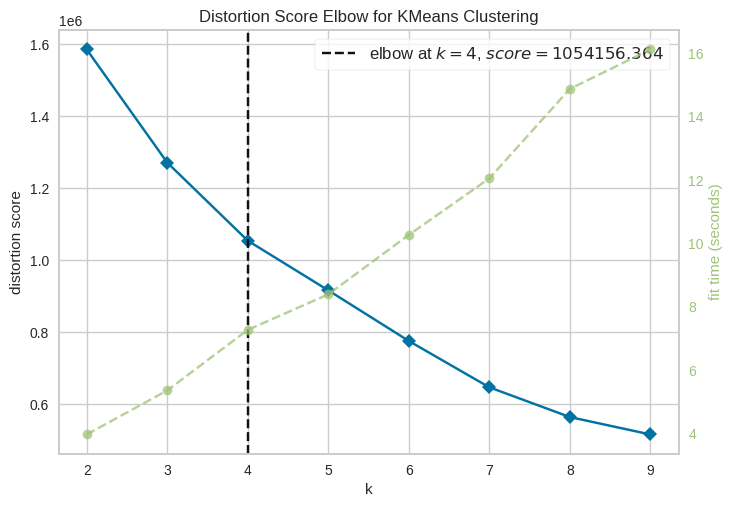

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Now, we can perform clustering on the above data
# This approaches uses distortion score to evaluate KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(model_scaled)   
visualizer.show()

In [43]:
## lets perform a K-means model with 4 number of clusters 
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(model_scaled)

KMeans(n_clusters=4, random_state=42)

### 5. understanding the clusters

In [44]:
# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the data frame
model_data['cluster'] = labels


In [45]:
cluster_data = model_data.groupby('cluster').mean()
cluster_data

,min_purchase_amount,max_purchase_amount,mean_purchase_amount,total_spending,avg_spending,merchant_diversity,number_of_transactions,min_purchase_recency_days,max_purchase_recency_days,mean_purchase_recency_days
cluster,,,,,,,,,,
0,-0.729699,12.407243,-0.391102,-27.483840,-0.391102,28.928015,70.028771,106.244416,447.050449,293.611223
1,-0.731964,6.917012,-0.434133,-27.769629,-0.434133,29.748338,60.738529,26.943317,250.766063,140.570552
2,-0.735647,29385.856259,454.720279,29773.349321,454.720279,49.866667,143.433333,59.003256,365.069714,236.196902
3,-0.742241,25.665162,-0.524161,-157.847248,-0.524161,102.255953,304.381671,24.145335,419.491610,230.114347


In [46]:
model_data['cluster'].value_counts()

cluster
1    94190
0    79280
3    28349
2       60
Name: count, dtype: int64

## clusters explainations 
* cluster 0 : they have average number of transactions and they considrerd to be the least active users according to the recency 
* cluster 1 : simillar to the first cluster but the diffrence is that they are more active[have less recency days ]
* cluster 2:  They have the max number of transcations and deals with alot of merchants . have the lowest total spending but according to recency this indicates that they had made a purchases recently
* cluster 3:  they have the greatest spending amount , moderate merchant diveristy , very high number of transactions , but they haven't made a purchase recently according to the average recency


### 6. Judging the Quality of the resultant clusters 

In [47]:
## i will judge the qaulity by using Silhouette Coefficient

from sklearn.metrics import silhouette_score

silhouette_coefficient = silhouette_score(model_data, model_data['cluster'])

print("Silhouette Coefficient:", silhouette_coefficient)

Silhouette Coefficient: 0.3666535818604223


#### Since the Silhouette Coefficient 0.36 which is less that 0.5 it's considred to be moderetly good but it could be improved 

### 7. Reporting the e statistics of loyalty scores for each cluster of users

In [48]:
## make another dataframe with the model data but join with it the score column

model_data.shape
merged_data.shape

(201879, 11)

(201917, 12)

In [49]:
## applying the boolean masks appplied on model_data to merged_data 
merged_data_2 = merged_data.copy()

## dropping outlier values 
merged_data_2= merged_data_2[merged_data_2['mean_purchase_amount']<10000]
merged_data_2= merged_data_2[merged_data_2['max_purchase_amount']<50000]

In [50]:
model_data.shape
merged_data_2.shape

(201879, 11)

(201879, 12)

In [51]:
merged_data_2.columns

Index(['card_id', 'min_purchase_amount', 'max_purchase_amount',
       'mean_purchase_amount', 'total_spending', 'min_purchase_recency',
       'max_purchase_recency', 'mean_purchase_recency', 'avg_spending',
       'merchant_diversity', 'number_of_transactions', 'score'],
      dtype='object')

In [52]:
model_data_2 = model_data.copy()

In [53]:
model_data_2.columns

Index(['min_purchase_amount', 'max_purchase_amount', 'mean_purchase_amount',
       'total_spending', 'avg_spending', 'merchant_diversity',
       'number_of_transactions', 'min_purchase_recency_days',
       'max_purchase_recency_days', 'mean_purchase_recency_days', 'cluster'],
      dtype='object')

In [54]:
score = merged_data_2['score']
model_data_2 = pd.concat([model_data_2, score], axis=1)
model_data_2.head()

,min_purchase_amount,max_purchase_amount,mean_purchase_amount,total_spending,avg_spending,merchant_diversity,number_of_transactions,min_purchase_recency_days,max_purchase_recency_days,mean_purchase_recency_days,cluster,score
0,-0.728876,1.507069,-0.518620,-78.830313,-0.518620,31,152,21.316667,440.416157,266.966794,0,0.134077
1,-0.740491,1.493545,-0.532896,-36.769844,-0.532896,29,69,39.614919,471.322199,154.439271,0,0.884295
2,-0.737892,2.764788,-0.491399,-78.623804,-0.491399,84,160,0.375069,266.590799,135.178912,1,-0.264433
3,-0.745871,-0.734135,-0.740649,-33.329209,-0.740649,12,45,101.494815,338.568553,250.495903,0,0.812872
4,-0.737892,-0.296112,-0.661958,-50.970769,-0.661958,44,77,37.636366,380.361921,206.094410,1,1.288514


In [55]:
cluster_stats = model_data_2.groupby('cluster')['score'].agg(['mean', 'median', 'std'])
cluster_stats

,mean,median,std
cluster,,,
0,-0.710313,-0.009210,5.211233
1,-0.131213,0.000000,2.521199
2,0.089496,-0.012214,1.379822
3,-0.380073,-0.113025,2.825087


### Reporting the Findings 
* Cluster 0 : Users in this cluster have low loyalty scores on average, with a wide range of scores and a skewed distribution.
* Cluster 1 : Users in this cluster have slightly higher loyalty scores on average than those in cluster 0, with a more balanced distribution of scores and less variation.
* Cluster 2 : Users in this cluster have higher loyalty scores on average than those in clusters 0 and 1, but still have negative scores overall. and there is moderate variation.
* CLuster 3 : Users in this cluster have high loyalty scores on average, with a roughly balanced distribution of scores between positive and negative values and relatively low variation.


### Visalizing the Clusters

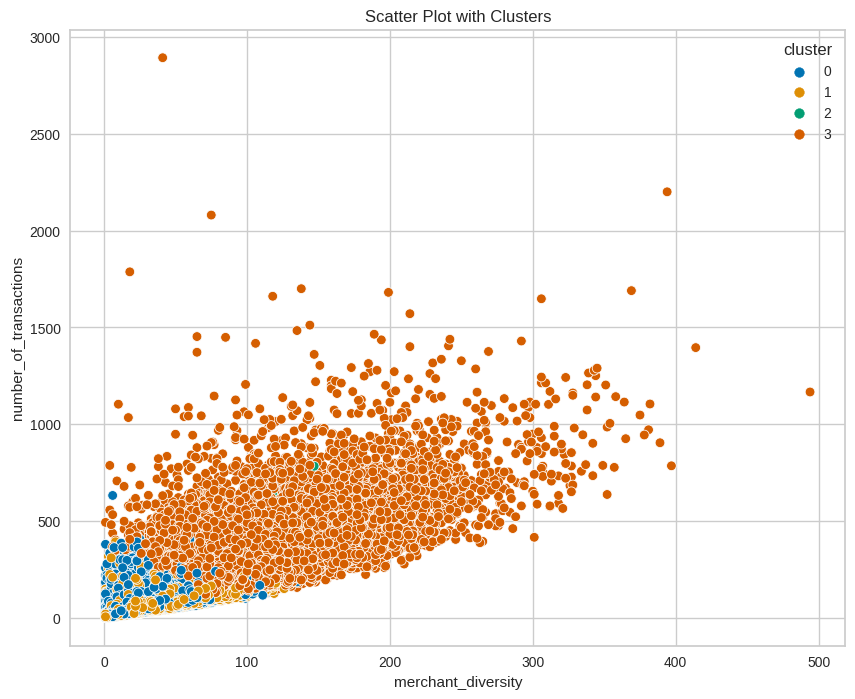

In [140]:
# Create a scatter plot of the principal components with different colors for each cluster
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x="merchant_diversity", y="number_of_transactions", hue="cluster", data=model_data_2, palette="colorblind")
ax.set_xlabel('merchant_diversity')
ax.set_ylabel('number_of_transactions')
ax.set_title('Scatter Plot with Clusters')
plt.show();

### 8. Denimntionallity Reduction

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principal_components = pca.fit_transform(model_data)

model_data_pca = pd.DataFrame(data = principal_components, 
                              columns = ['PC1', 'PC2'])


model_data_pca.head()
model_data_pca.shape

,PC1,PC2
0,-43.317138,-104.623220
1,-13.007746,-39.384376
2,-42.329969,86.450158
3,-11.889613,4.917171
4,-24.400617,-4.649355


(201879, 2)

### 9. Performing  K-means model and tring to find out the optimal K after PCA

In [57]:
from sklearn.preprocessing import StandardScaler
# feature normalization.
scaler = StandardScaler()
model_scaled = scaler.fit_transform(model_data_pca)


KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(2, 10))

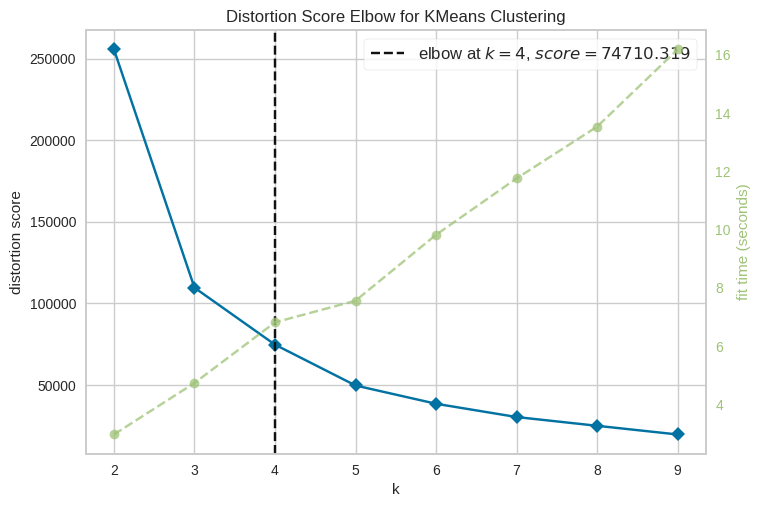

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
# Now, we can perform clustering on the above data
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(model_scaled)   
visualizer.show()

In [59]:
## lets perform a K-means model with 4 number of clusters 
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(model_scaled)

KMeans(n_clusters=4, random_state=42)

### 10. comparing between Before PCA and After PCA

In [60]:
# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the data frame
model_data_pca['cluster'] = labels


In [61]:
cluster_data = model_data_pca.groupby('cluster').mean()
cluster_data

,PC1,PC2
cluster,,
0,-35.377600,-119.519862
1,-8.559332,139.828116
2,48092.644953,-149.272566
3,12257.159083,-121.096749


In [62]:
model_data_pca['cluster'].value_counts()

cluster
0    108596
1     93042
3       194
2        47
Name: count, dtype: int64

In [63]:
## i will judge the qaulity by using Silhouette Coefficient

silhouette_coefficient = silhouette_score(model_data_pca, model_data_pca['cluster'])

print("Silhouette Coefficient:", silhouette_coefficient)

Silhouette Coefficient: 0.5628731067553767


#### Since the Silhouette Coefficient 0.562 it means that applying PCA improved the clustering 

### 11. statistics of loyalty scores for each cluster of users

In [64]:
model_data_pca_2 = model_data_pca.copy()

In [65]:
score = merged_data_2['score']
model_data_pca_2 = pd.concat([model_data_pca, score], axis=1)
model_data_pca_2.head()

,PC1,PC2,cluster,score
0,-43.317138,-104.623220,0.0,0.134077
1,-13.007746,-39.384376,0.0,0.884295
2,-42.329969,86.450158,1.0,-0.264433
3,-11.889613,4.917171,0.0,0.812872
4,-24.400617,-4.649355,0.0,1.288514


In [66]:
cluster_stats = model_data_pca_2.groupby('cluster')['score'].agg(['mean', 'median', 'std'])
cluster_stats

,mean,median,std
cluster,,,
0.0,-0.400104,-0.022910,3.883344
1.0,-0.385508,-0.024044,3.809491
2.0,-1.164427,0.200025,7.017505
3.0,-0.432551,-0.002675,3.802131


### Reporting the Findings 
* Cluster 0 : the users in this cluster have a relatively low average score, with a moderate level of variation.
* Cluster 1 : the users in this cluster have a similar average score to those in Cluster 0, with a similar level of variation.
* Cluster 2 : the users in this cluster have a significantly lower average score than those in Clusters 0 and 1, with a higher level of variation.
* CLuster 3 : the users in this cluster have a similar average score to those in Clusters 0 and 1, with a similar level of variation.

### 12. Clusters visaulization.

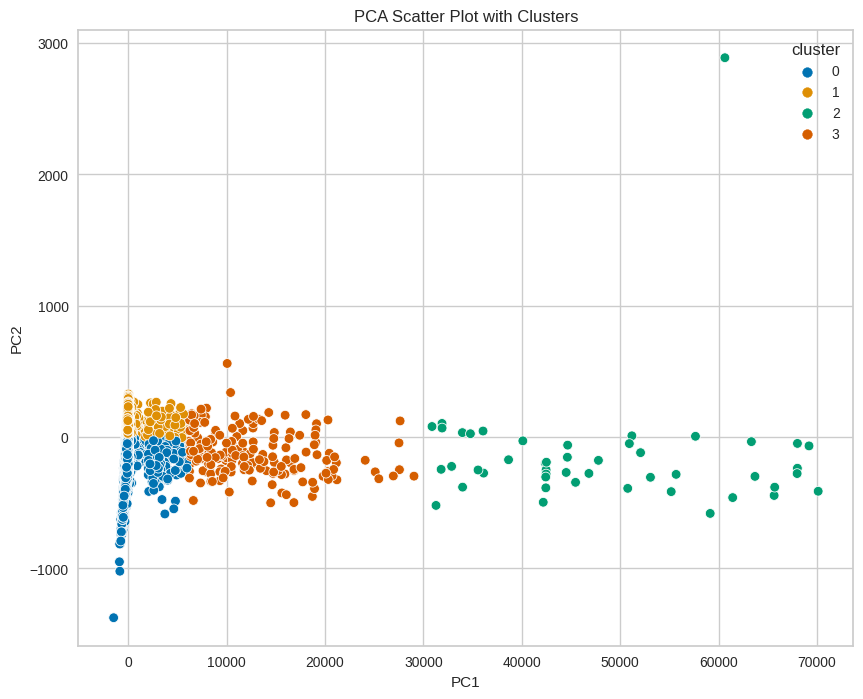

In [67]:
import seaborn as sns

# Create a scatter plot of the principal components with different colors for each cluster
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=model_data_pca, palette="colorblind")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Scatter Plot with Clusters')
plt.show();

# Frequent Pattern Mining 

### 13. finding frequently co-occurring transaction types

In [68]:
transactions.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [69]:
# Change the data type of some columns to object
transactions_2 =transactions.copy()

transactions_2['city_id'] = transactions_2['city_id'].astype('object')
transactions_2['merchant_category_id'] = transactions_2['merchant_category_id'].astype('object')
transactions_2['state_id'] = transactions_2['state_id'].astype('object')
transactions_2['subsector_id'] = transactions_2['subsector_id'].astype('object')

In [70]:
print(transactions_2.dtypes)

authorized_flag          object
card_id                  object
city_id                  object
category_1               object
installments              int64
category_3               object
merchant_category_id     object
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                 object
subsector_id             object
dtype: object


In [71]:
transactions_2['city_id'].nunique()
transactions_2['category_1'].nunique()
transactions_2['category_3'].nunique()
transactions_2['state_id'].nunique()
transactions_2['authorized_flag'].nunique()

308

2

3

25

2

In [72]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#  one-hot encoded dataframe for the relevant features
features = pd.get_dummies(transactions_2[['category_1', 'category_3','state_id','authorized_flag']])

In [73]:
# Use the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(features, min_support=0.05, use_colnames=True)

In [74]:
print(features.dtypes)

category_1_N         bool
category_1_Y         bool
category_3_A         bool
category_3_B         bool
category_3_C         bool
state_id_-1          bool
state_id_1           bool
state_id_2           bool
state_id_3           bool
state_id_4           bool
state_id_5           bool
state_id_6           bool
state_id_7           bool
state_id_8           bool
state_id_9           bool
state_id_10          bool
state_id_11          bool
state_id_12          bool
state_id_13          bool
state_id_14          bool
state_id_15          bool
state_id_16          bool
state_id_17          bool
state_id_18          bool
state_id_19          bool
state_id_20          bool
state_id_21          bool
state_id_22          bool
state_id_23          bool
state_id_24          bool
authorized_flag_N    bool
authorized_flag_Y    bool
dtype: object


In [75]:
# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [76]:
# Print the frequent itemsets and association rules
print("Frequent Itemsets:")
print(frequent_itemsets)
print("\nAssociation Rules:")
print(rules)

Frequent Itemsets:
     support                                           itemsets
0   0.930906                                     (category_1_N)
1   0.069094                                     (category_1_Y)
2   0.525625                                     (category_3_A)
3   0.402688                                     (category_3_B)
4   0.064154                                     (category_3_C)
5   0.088965                                      (state_id_-1)
6   0.057128                                       (state_id_5)
7   0.363697                                       (state_id_9)
8   0.072004                                      (state_id_15)
9   0.073472                                      (state_id_16)
10  0.080994                                (authorized_flag_N)
11  0.919006                                (authorized_flag_Y)
12  0.525534                       (category_3_A, category_1_N)
13  0.348879                       (category_3_B, category_1_N)
14  0.057128         

#### Findings : 
my findings showed that the most frequent transaction types were authorized_flag_Y, category_1_N. i also found several interesting association rules, such as the rule that category_3_B and category_1_N tend to occur together, and the rule that authorized_flag_Y and category_1_N tend to occur together.

#### How i picked the minimum support threshold:
i chose a minimum support threshold of 0.05 based on our understanding of the dataset and our goals for the analysis. Specifically, i wanted to identify transaction types that occurred frequently enough to be considered meaningful, while still keeping the number of itemsets manageable.

i looked at the distribution of transaction types in the dataset and considered the trade-off between support and itemset size. i found that a threshold of 0.05 allowed me to identify a sufficient number of frequent itemsets while still keeping the itemset size manageable.

i also experimented with different thresholds and evaluated the results based on the number and quality of the generated itemsets and association rules. i found that a threshold of 0.05 provided a good balance between the number and quality of the generated itemsets and association rules.

### 14. Frequent pattern mining by splitting users based on their loyalty scores

In [77]:
score_and_transactions_2 = score_and_transactions.copy()

In [78]:
#  relevant features
features =score_and_transactions_2 [['category_1', 'category_3','state_id','authorized_flag','score']]

In [79]:
features.loc[:, 'state_id'] = features['state_id'].astype('object')

In [80]:
## classifying the users based on therir loyalty score
high_loyal = features[features['score']> features['score'].mean()]
low_loyal = features[features['score']<features['score'].mean()]

high_loyal

low_loyal

,category_1,category_3,state_id,authorized_flag,score
283,N,C,9,Y,0.392913
284,N,B,9,Y,0.392913
285,N,C,9,Y,0.392913
286,N,B,9,Y,0.392913
287,N,B,15,Y,0.392913
...,...,...,...,...,...
19249516,N,B,9,Y,0.093494
19249517,N,B,7,Y,0.093494
19249518,N,B,8,Y,0.093494
19249519,Y,C,-1,Y,0.093494


,category_1,category_3,state_id,authorized_flag,score
0,N,A,9,Y,-0.820283
1,N,A,9,Y,-0.820283
2,N,A,9,Y,-0.820283
3,N,A,9,Y,-0.820283
4,N,A,9,Y,-0.820283
...,...,...,...,...,...
19249689,N,B,7,Y,-1.859413
19249690,N,NaN,7,Y,-1.859413
19249691,N,NaN,7,Y,-1.859413
19249692,N,B,7,Y,-1.859413


In [81]:
# dropping the score column 
high_loyal.drop('score',axis=1,inplace=True)
low_loyal.drop('score',axis=1,inplace=True)

/tmp/ipykernel_318/2141165058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_loyal.drop('score',axis=1,inplace=True)
/tmp/ipykernel_318/2141165058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_loyal.drop('score',axis=1,inplace=True)


In [102]:
## one-hot encoding 
high_loyal = pd.get_dummies(high_loyal)
low_loyal = pd.get_dummies(low_loyal)


In [104]:
high_loyal.dtypes


category_1_N         int64
category_1_Y         int64
category_3_A         int64
category_3_B         int64
category_3_C         int64
state_id_-1          int64
state_id_1           int64
state_id_2           int64
state_id_3           int64
state_id_4           int64
state_id_5           int64
state_id_6           int64
state_id_7           int64
state_id_8           int64
state_id_9           int64
state_id_10          int64
state_id_11          int64
state_id_12          int64
state_id_13          int64
state_id_14          int64
state_id_15          int64
state_id_16          int64
state_id_17          int64
state_id_18          int64
state_id_19          int64
state_id_20          int64
state_id_21          int64
state_id_22          int64
state_id_23          int64
state_id_24          int64
authorized_flag_N    int64
authorized_flag_Y    int64
dtype: object

In [105]:
low_loyal.dtypes


category_1_N         int64
category_1_Y         int64
category_3_A         int64
category_3_B         int64
category_3_C         int64
state_id_-1          int64
state_id_1           int64
state_id_2           int64
state_id_3           int64
state_id_4           int64
state_id_5           int64
state_id_6           int64
state_id_7           int64
state_id_8           int64
state_id_9           int64
state_id_10          int64
state_id_11          int64
state_id_12          int64
state_id_13          int64
state_id_14          int64
state_id_15          int64
state_id_16          int64
state_id_17          int64
state_id_18          int64
state_id_19          int64
state_id_20          int64
state_id_21          int64
state_id_22          int64
state_id_23          int64
state_id_24          int64
authorized_flag_N    int64
authorized_flag_Y    int64
dtype: object

In [114]:
high_loyal= high_loyal.astype('bool')
low_loyal=low_loyal.astype('bool')

In [115]:
high_loyal.dtypes
low_loyal.dtypes

category_1_N         bool
category_1_Y         bool
category_3_A         bool
category_3_B         bool
category_3_C         bool
state_id_-1          bool
state_id_1           bool
state_id_2           bool
state_id_3           bool
state_id_4           bool
state_id_5           bool
state_id_6           bool
state_id_7           bool
state_id_8           bool
state_id_9           bool
state_id_10          bool
state_id_11          bool
state_id_12          bool
state_id_13          bool
state_id_14          bool
state_id_15          bool
state_id_16          bool
state_id_17          bool
state_id_18          bool
state_id_19          bool
state_id_20          bool
state_id_21          bool
state_id_22          bool
state_id_23          bool
state_id_24          bool
authorized_flag_N    bool
authorized_flag_Y    bool
dtype: object

category_1_N         bool
category_1_Y         bool
category_3_A         bool
category_3_B         bool
category_3_C         bool
state_id_-1          bool
state_id_1           bool
state_id_2           bool
state_id_3           bool
state_id_4           bool
state_id_5           bool
state_id_6           bool
state_id_7           bool
state_id_8           bool
state_id_9           bool
state_id_10          bool
state_id_11          bool
state_id_12          bool
state_id_13          bool
state_id_14          bool
state_id_15          bool
state_id_16          bool
state_id_17          bool
state_id_18          bool
state_id_19          bool
state_id_20          bool
state_id_21          bool
state_id_22          bool
state_id_23          bool
state_id_24          bool
authorized_flag_N    bool
authorized_flag_Y    bool
dtype: object

In [128]:
## for high loyal score users 
# Use the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(high_loyal, min_support=0.05, use_colnames=True)

# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Print the frequent itemsets and association rules
print("Frequent Itemsets For high loyalty users:")
print(frequent_itemsets)
print("\nAssociation RulesFor high loyalty users:")
print(rules)

Frequent Itemsets For high loyalty users:
     support                                           itemsets
0   0.930920                                     (category_1_N)
1   0.069080                                     (category_1_Y)
2   0.511500                                     (category_3_A)
3   0.415608                                     (category_3_B)
4   0.065159                                     (category_3_C)
5   0.089207                                      (state_id_-1)
6   0.057152                                       (state_id_5)
7   0.365319                                       (state_id_9)
8   0.071276                                      (state_id_15)
9   0.073310                                      (state_id_16)
10  0.080453                                (authorized_flag_N)
11  0.919547                                (authorized_flag_Y)
12  0.511422                       (category_3_A, category_1_N)
13  0.361850                       (category_3_B, category_1_N

#### Findings : 
my findings showed that the most frequent transaction types among high loyalty users were category_1_N, category_3_A, category_3_B, and authorized_flag_Y. The most frequent association rule was between category_3_B, authorized_flag_Y, and category_1_N.

The generated association rules suggest that there are certain patterns in the transaction types that are more likely to occur together among high loyalty users. For example, we found that high loyalty users who had category_1_N were more likely to have category_3_A and state_id_9. Additionally, we found that high loyalty users who had authorized_flag_Y were more likely to have category_3_B and category_1_N.

#### How i picked the minimum support threshold:
i chose a minimum support threshold of 0.05 based on our understanding of the dataset and our goals for the analysis. Specifically, i wanted to identify transaction types that occurred frequently enough to be considered meaningful, while still keeping the number of itemsets manageable.

i looked at the distribution of transaction types in the dataset and considered the trade-off between support and itemset size. i found that a threshold of 0.05 allowed me to identify a sufficient number of frequent itemsets while still keeping the itemset size manageable.

i also experimented with different thresholds and evaluated the results based on the number and quality of the generated itemsets and association rules. i found that a threshold of 0.05 provided a good balance between the number and quality of the generated itemsets and association rules.

In [121]:
## for low loyal score users 

# Use the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(low_loyal, min_support=0.05, use_colnames=True)

# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Print the frequent itemsets and association rules
print("Frequent Itemsets For low loyalty users:")
print(frequent_itemsets)
print("\nAssociation Rules For low loyalty users::")
print(rules)

Frequent Itemsets For low loyalty users:
     support                                           itemsets
0   0.931296                                     (category_1_N)
1   0.068704                                     (category_1_Y)
2   0.552513                                     (category_3_A)
3   0.377660                                     (category_3_B)
4   0.062632                                     (category_3_C)
5   0.087623                                      (state_id_-1)
6   0.055922                                       (state_id_5)
7   0.362986                                       (state_id_9)
8   0.072571                                      (state_id_15)
9   0.074609                                      (state_id_16)
10  0.082390                                (authorized_flag_N)
11  0.917610                                (authorized_flag_Y)
12  0.552416                       (category_3_A, category_1_N)
13  0.324444                       (category_3_B, category_1_N)

#### Findings : 
my findings showed that found that the most frequent transaction types among low loyalty users were category_1_N, category_3_A, category_3_B, and authorized_flag_Y. The most frequent association rule was between category_3_A, authorized_flag_Y, and category_1_N.

The generated association rules suggest that there are certain patterns in the transaction types that are more likely to occur together among low loyalty users. For example, i found that low loyalty users who had category_1_N were more likely to have category_3_A and state_id_9. Additionally, i found that low loyalty users who had authorized_flag_Y were more likely to have category_3_B and category_1_N.

#### How i picked the minimum support threshold:
i chose a minimum support threshold of 0.05 based on our understanding of the dataset and our goals for the analysis. Specifically, i wanted to identify transaction types that occurred frequently enough to be considered meaningful, while still keeping the number of itemsets manageable.

i looked at the distribution of transaction types in the dataset and considered the trade-off between support and itemset size. i found that a threshold of 0.05 allowed me to identify a sufficient number of frequent itemsets while still keeping the itemset size manageable.

i also experimented with different thresholds and evaluated the results based on the number and quality of the generated itemsets and association rules. i found that a threshold of 0.05 provided a good balance between the number and quality of the generated itemsets and association rules.